In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import datasets,transforms
from torch.utils.data import DataLoader

In [2]:
train_data= datasets.FashionMNIST(root='data',
                                  download=True,
                                  train=True,
                                  transform=transforms.ToTensor(),
                                  )
test_data= datasets.FashionMNIST(root='data',
                                  download=True,
                                  train=False,
                                  transform=transforms.ToTensor(),
                                  )

100%|██████████| 26.4M/26.4M [00:02<00:00, 13.2MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 208kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.89MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 17.5MB/s]


In [3]:
image,label=train_data[0]
image.shape,label

(torch.Size([1, 28, 28]), 9)

In [4]:
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)


(60000, 60000, 10000, 10000)

In [5]:
class_names=train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [6]:
class_names[label]

'Ankle boot'

In [7]:
random_idx=torch.randint(0,len(train_data),size=[1]).item()
random_idx

25203

In [8]:
image,label=train_data[random_idx]
image.permute(1,2,0).shape

torch.Size([28, 28, 1])

## Visualizing some images

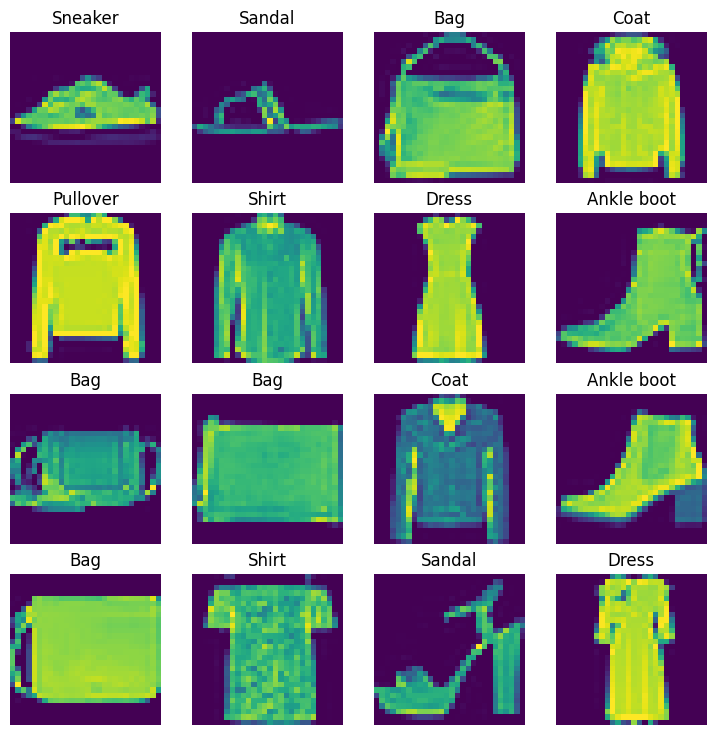

In [9]:
rows,columns=4,4
fig=plt.figure(figsize=(9,9))
for i in range(1,rows*columns+1):
  random_idx=torch.randint(0,len(train_data),size=[1]).item()
  image,label=train_data[random_idx]
  fig.add_subplot(rows,columns,i)
  plt.imshow(image.permute(1,2,0))
  plt.title(class_names[label])
  plt.axis(False)

plt.show()



In [10]:
# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE,shuffle=True)

test_dataloader = DataLoader(test_data,batch_size=BATCH_SIZE,shuffle=False)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x78554fdc5950>, <torch.utils.data.dataloader.DataLoader object at 0x78554fe9b450>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [11]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [12]:
train_features_batch[0], train_labels_batch[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0157, 0.5608, 0.6039, 0.3922, 0.2431, 0.2627, 0.2627,
           0.3882, 0.8235, 0.3686, 0.0000, 0.0000, 0.0157, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0157, 0.0000,
           0.1647, 0.8902, 0.7961, 0.6392, 0.5294, 0.4353, 0.4000, 0.5608,
           0.4392, 0.6863, 0.8078, 0.7333, 0.0000, 0.0000, 0.0039, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.6824, 0.7686, 0.7333, 0.7333, 0.4706, 0.4588, 0.5294, 0.4118,
           0.6510, 0.7333, 0.7216, 0.8549, 0.3922, 0.0000, 0.0118, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6510,
           0.8980, 0.7176, 0.7529, 0.7451, 0.6196, 0.4549, 0.5255, 0.4824,
           0.6549, 0.7294, 0.7765, 0.7412, 

## Building the model

In [13]:
class FashionMNISTModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # flatten inputs into single vector
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )

    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = FashionMNISTModel(input_shape=28*28, hidden_units=10, output_shape=len(class_names)).to(device)
next(model.parameters()).device

device(type='cuda', index=0)

In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),lr=0.1)

## training and testing functions

In [16]:
def train_step(model, dataloader, loss_fn, optimizer, device):
    model.train()
    total_loss, total_acc = 0, 0

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        # Forward
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        total_loss += loss.item()

        # Accuracy
        preds = torch.argmax(y_pred, 1)
        total_acc += (preds == y).sum().item()

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(dataloader)
    avg_acc = total_acc / (len(dataloader.dataset))
    return avg_loss, avg_acc


def test_step(model, dataloader, loss_fn, device):
    model.eval()
    total_loss, total_acc = 0, 0

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            total_loss += loss.item()

            preds = torch.argmax(y_pred, 1)
            total_acc += (preds == y).sum().item()

    avg_loss = total_loss / len(dataloader)
    avg_acc = total_acc / (len(dataloader.dataset))
    return avg_loss, avg_acc


## Evaluation function

In [17]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               device: torch.device = device):

    model.eval()
    total_loss = 0
    total_correct = 0

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)

            # Loss
            loss = loss_fn(y_pred, y)
            total_loss += loss.item()

            # Accuracy
            preds = y_pred.argmax(dim=1)
            total_correct += (preds == y).sum().item()

    avg_loss = total_loss / len(data_loader)
    avg_acc = total_correct / len(data_loader.dataset)

    return {
        "model_name": model.__class__.__name__,
        "model_loss": avg_loss,
        "model_acc": avg_acc
    }




In [18]:
epochs = 6

from tqdm.auto import tqdm

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)
    test_loss, test_acc = test_step(model, test_dataloader, loss_fn, device)

    print(f"Epoch {epoch+1}:")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%")
    print(f"  Test Loss:  {test_loss:.4f}, Test Acc:  {test_acc*100:.2f}%")



  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1:
  Train Loss: 0.8409, Train Acc: 72.40%
  Test Loss:  0.7107, Test Acc:  79.70%
Epoch 2:
  Train Loss: 0.6461, Train Acc: 79.92%
  Test Loss:  0.5054, Test Acc:  82.52%
Epoch 3:
  Train Loss: 0.4565, Train Acc: 83.92%
  Test Loss:  0.5077, Test Acc:  82.30%
Epoch 4:
  Train Loss: 0.4339, Train Acc: 84.46%
  Test Loss:  0.4602, Test Acc:  83.72%
Epoch 5:
  Train Loss: 0.4183, Train Acc: 84.96%
  Test Loss:  0.4687, Test Acc:  83.32%
Epoch 6:
  Train Loss: 0.4097, Train Acc: 85.38%
  Test Loss:  0.4483, Test Acc:  83.86%


In [19]:
model_results = eval_model(model=model,data_loader=test_dataloader,loss_fn=loss_fn,device=device)
model_results


{'model_name': 'FashionMNISTModel',
 'model_loss': 0.44831410502663815,
 'model_acc': 0.8386}

## Seeing how well can the model predicts correctly

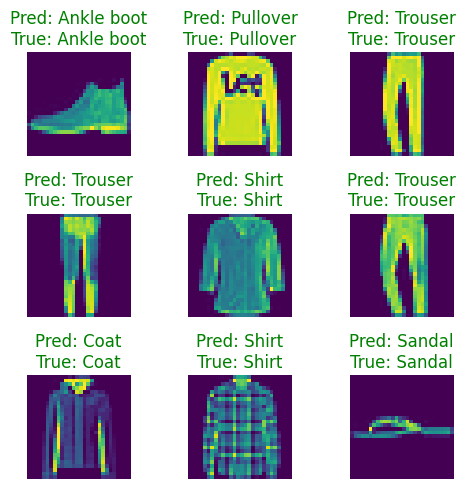

In [20]:
def plot_predictions(model, dataloader, class_names, device, n=9):
    model.eval()
    X_batch, y_batch = next(iter(dataloader))
    X_batch, y_batch = X_batch.to(device), y_batch.to(device)

    with torch.inference_mode():
        y_pred = model(X_batch)
        pred_classes = torch.argmax(y_pred, 1)

    plt.figure(figsize=(5, 5))
    for i in range(n):
        plt.subplot(3, 3, i+1)
        plt.imshow(X_batch[i].permute(1, 2, 0).cpu())
        color = 'g' if pred_classes[i] == y_batch[i] else 'r'
        plt.title(f"Pred: {class_names[pred_classes[i]]}\nTrue: {class_names[y_batch[i]]}", c=color)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

plot_predictions(model, test_dataloader, class_names, device)


## Making a confusion matrix for further prediction evaluation

In [21]:
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
except:
    !pip install -q torchmetrics -U mlxtend # for installing mlxtend upgraded version
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.9/981.9 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.5 MB/s eta 0:00:00
mlxtend version: 0.23.4


In [22]:
# Get predictions
y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    X, y = X.to(device), y.to(device)
    y_logit = model(X)
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

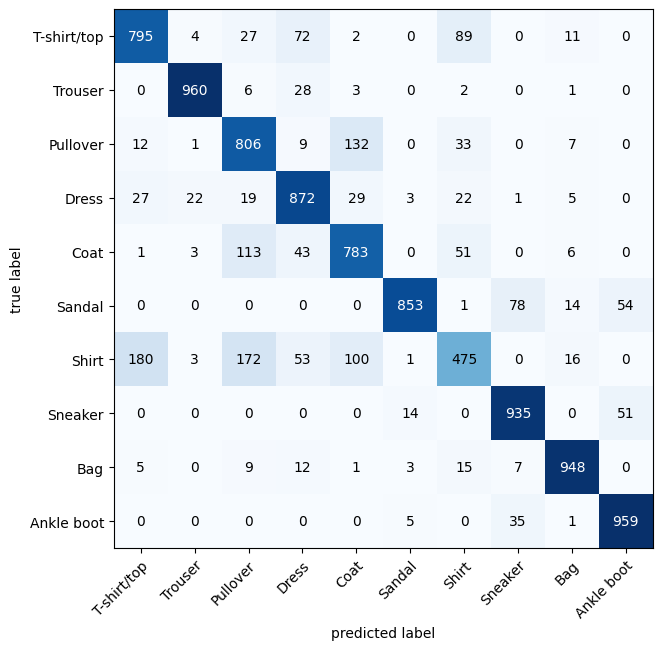

In [23]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

#**Done 🚀🚀🚀😊😊😊**